Adapted from [NYU Deep Learning](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/10-autoencoder.ipynb)

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(8):
                plt.subplot(1,8,i+1)
                plt.imshow(in_pic[i+8*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(8):
            plt.subplot(1,8,i+1)
            plt.imshow(out_pic[i+8*N])
            plt.axis('off')

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define AE architecture & Initiate a model instance

In [ ]:
# n = 28 x 28 = 784
d = 30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = AE().to(device)

## Define loss (reconstruction loss)


In [ ]:
criterion = nn.MSELoss()

## Define optimizer

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

## Train standard AE

epoch [1/10], loss:0.1945
epoch [2/10], loss:0.1478
epoch [3/10], loss:0.1269
epoch [4/10], loss:0.1055
epoch [5/10], loss:0.0947
epoch [6/10], loss:0.0952
epoch [7/10], loss:0.0869
epoch [8/10], loss:0.0863
epoch [9/10], loss:0.0744
epoch [10/10], loss:0.0780


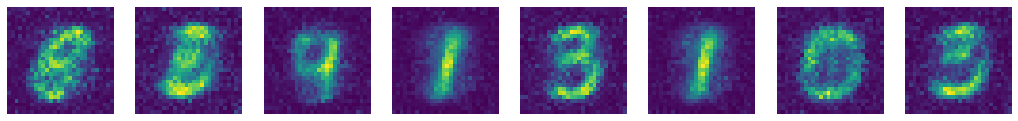

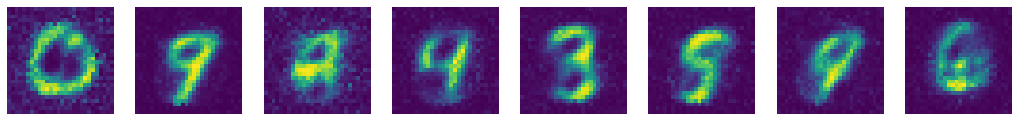

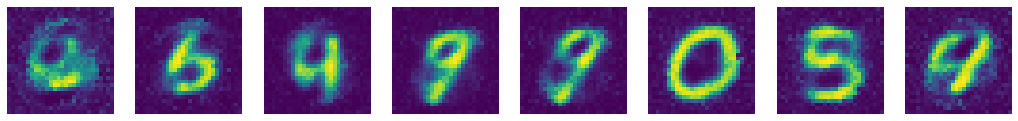

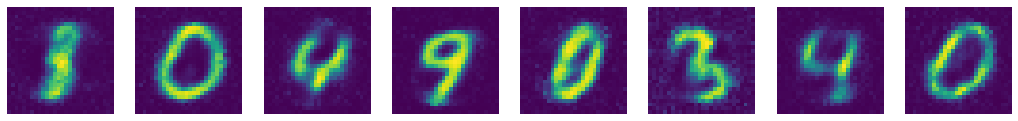

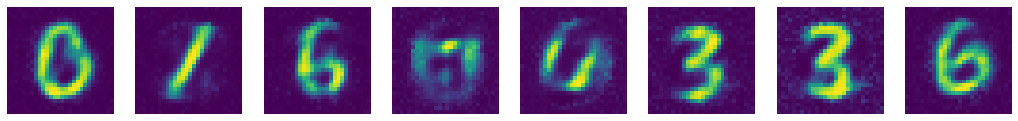

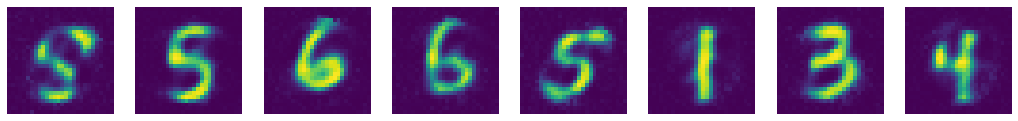

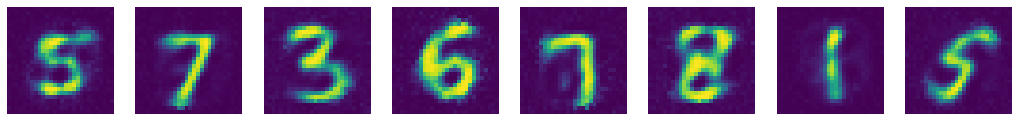

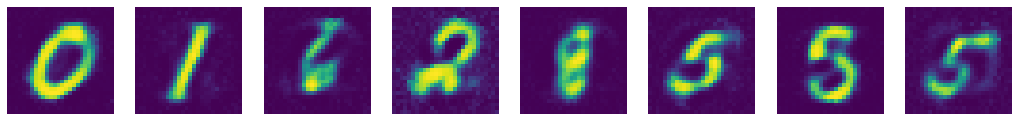

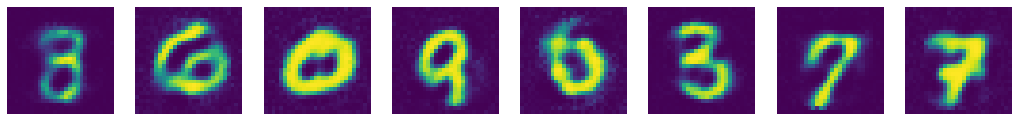

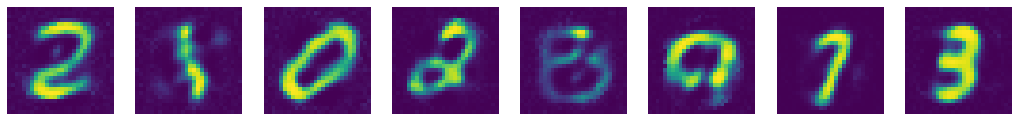

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)

## Visualize some kernels of the encoder

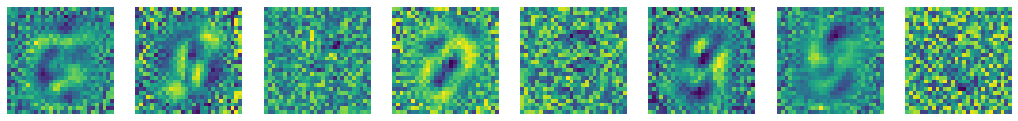

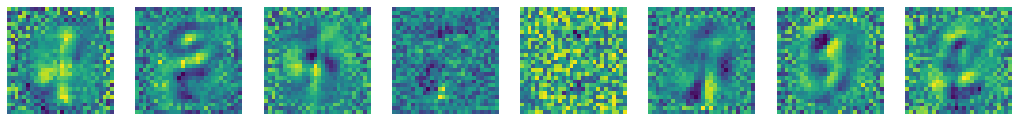

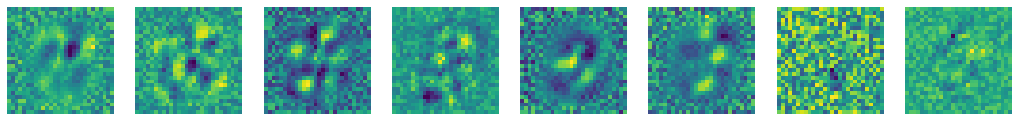

In [ ]:
display_images(None, model.encoder[0].weight, 3)

## Train denoising AE (DAE)

epoch [1/10], loss:0.0951
epoch [2/10], loss:0.0910
epoch [3/10], loss:0.0892
epoch [4/10], loss:0.0958
epoch [5/10], loss:0.0917
epoch [6/10], loss:0.0931
epoch [7/10], loss:0.0846
epoch [8/10], loss:0.0913
epoch [9/10], loss:0.0878
epoch [10/10], loss:0.0859


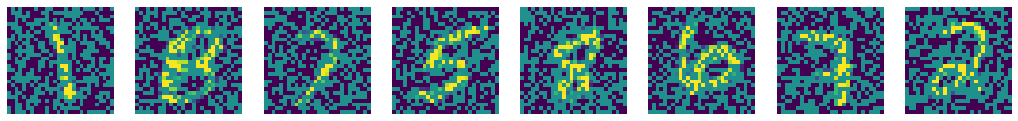

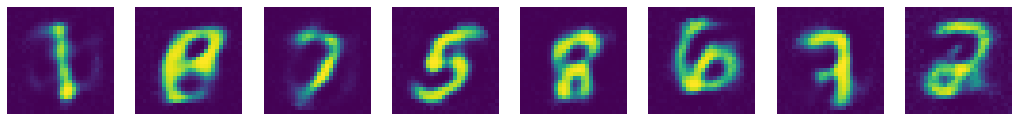

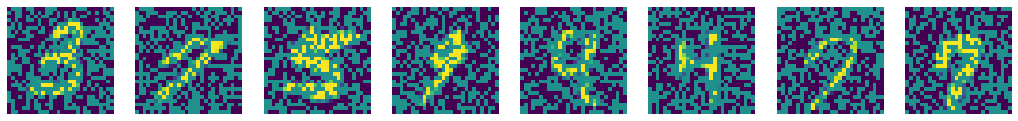

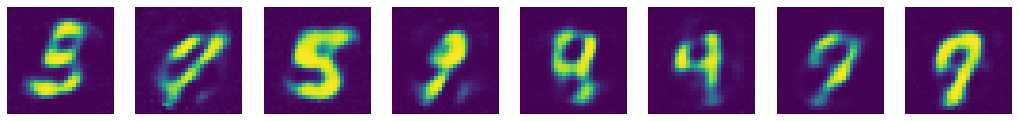

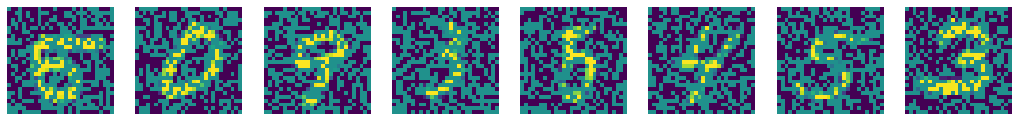

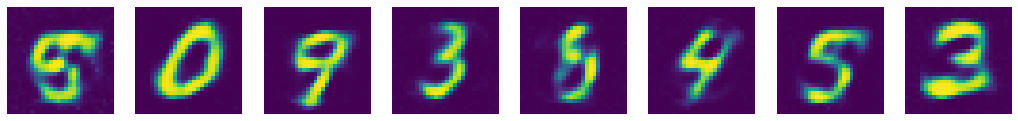

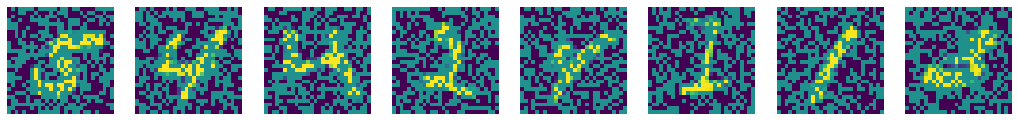

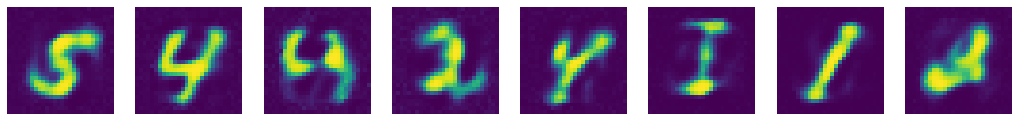

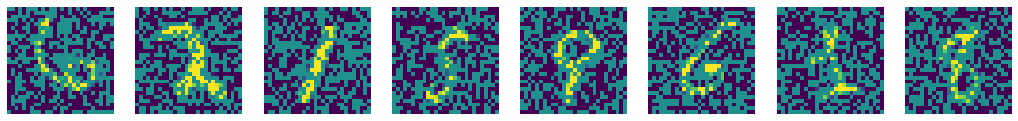

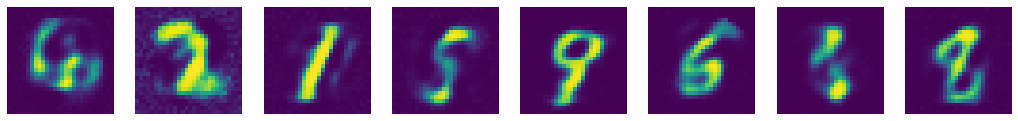

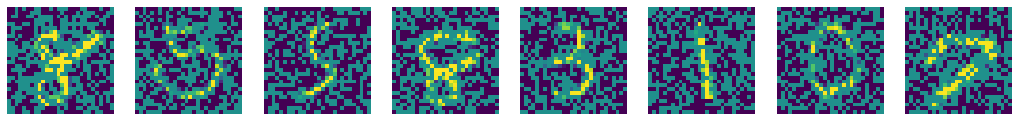

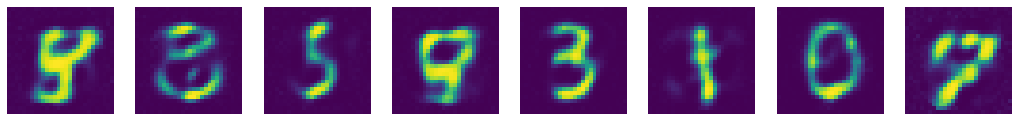

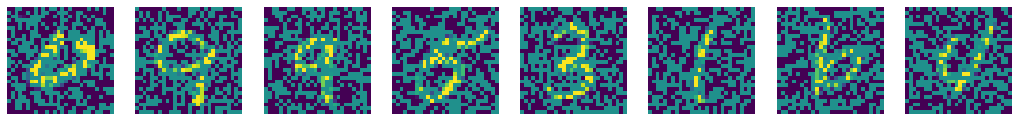

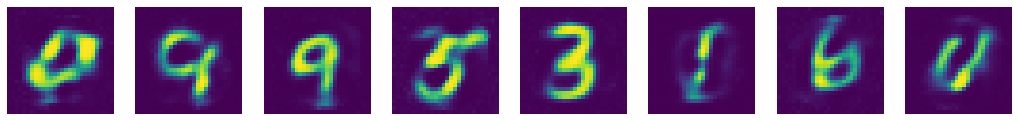

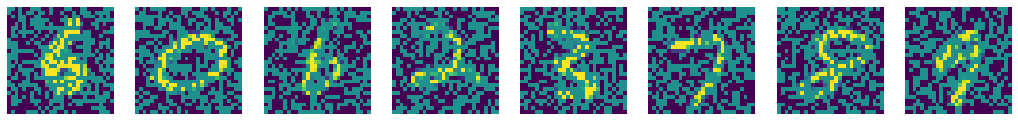

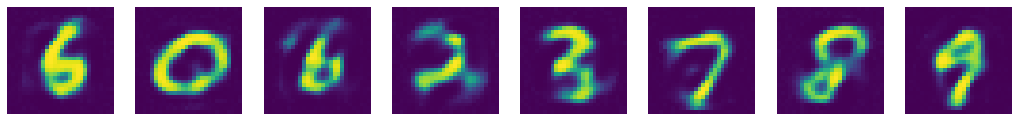

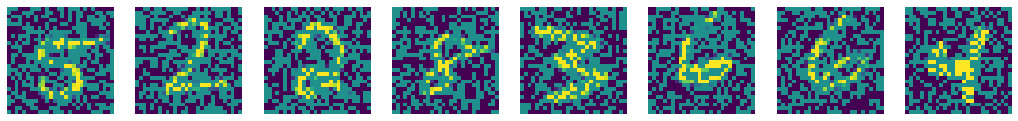

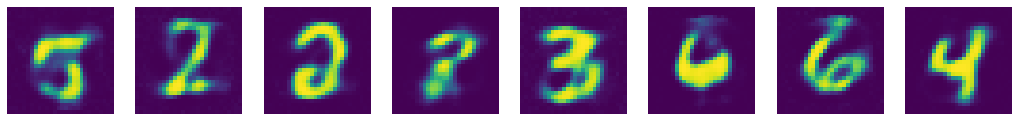

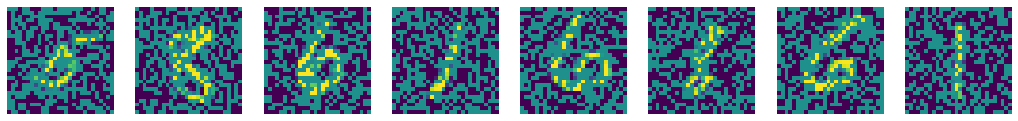

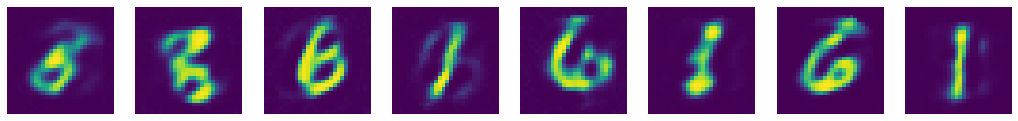

In [ ]:
num_epochs = 10
do = nn.Dropout() #noises are created using nn.Dropout().
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)
        # ===================forward=====================
        output = model(img_bad)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)

## Try to code CNN encoder & decoder.